In [110]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import time
import os
import copy
import shutil
from sklearn.model_selection import train_test_split
import pandas as pd

cudnn.benachmark = True

In [40]:
DATA_PATH = r"CaptchaDateien"
test_size = 0.15

In [27]:
# Load data

In [3]:
image_dataset = datasets.ImageFolder(os.path.join(DATA_PATH, r'train_val'))


In [4]:
image_dataset[0]

(<PIL.Image.Image image mode=RGB size=120x120>, 0)

In [29]:
# View targets and distribution

In [30]:
image_dataset.class_to_idx

{'Bicycle': 0,
 'Bridge': 1,
 'Bus': 2,
 'Car': 3,
 'Chimney': 4,
 'Crosswalk': 5,
 'Hydrant': 6,
 'Motorcycle': 7,
 'Other': 8,
 'Palm': 9,
 'Stair': 10,
 'Traffic Light': 11}

In [31]:
targets = image_dataset.targets

In [84]:
target_arr = np.array(targets)
target_distribution = np.unique(target_arr, return_counts=True)
target_distribution

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([200, 136, 309, 910,  32, 317, 243,  21, 343, 233,  54, 202],
       dtype=int64))

In [ ]:
# Load Test

In [ ]:
image_testset = datasets.ImageFolder(os.path.join(DATA_PATH, r'test'))


In [34]:
# Train and validation split

In [41]:
train_indices, val_indices, _, _ = train_test_split(
    range(len(image_dataset)),
    image_dataset.targets,
    test_size=test_size,
    random_state=10,
    stratify=image_dataset.targets
)

In [95]:
len(train_indices)

2550

In [96]:
len(val_indices)

450

In [42]:
train_dataset = torch.utils.data.Subset(image_dataset, train_indices)
validation_dataset = torch.utils.data.Subset(image_dataset, val_indices)

In [99]:
assert len(train_dataset) == (1-test_size)*len(image_dataset)
assert len(validation_dataset) == test_size*len(image_dataset)
assert len(train_indices) + len(val_indices) == len(image_dataset)

In [86]:
# check class distributions

In [101]:
train_distribution =  {}
validation_distribution = {}

In [102]:
for x in train_dataset: 
    try:
        train_distribution[x[1]] = train_distribution[x[1]] + 1
    except:
        train_distribution[x[1]]= 1

for x in validation_dataset:
    try:
        validation_distribution[x[1]] = validation_distribution[x[1]] + 1
    except: 
        validation_distribution[x[1]] = 1

sorted_train_dist = sorted(list(train_distribution.items()))
sorted_val_dist = sorted(list(validation_distribution.items()))

In [103]:
train_distribution = (np.array([x[0] for x in sorted_train_dist]), np.array([x[1] for x in sorted_train_dist]))
val_distribution = (np.array([x[0] for x in sorted_val_dist]), np.array(np.array([x[1] for x in sorted_val_dist])))

In [104]:
train_distribution

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([170, 116, 263, 773,  27, 269, 207,  18, 291, 198,  46, 172]))

In [105]:
val_distribution

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([ 30,  20,  46, 137,   5,  48,  36,   3,  52,  35,   8,  30]))

In [109]:
assert np.array_equal(np.array([x for x in train_distribution[1]]) + np.array([x for x in val_distribution[1]]), target_distribution[1])

In [123]:
class ApplyTransform(Dataset): 
    """Apply transformations to each item in the dataset

    :param Dataset: Extends Dataset
    :type Dataset: Dataset
    """

    def __init__(self, dataset, transform = None, target_transform = None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform
    
    def __getitem__(self, idx): 
        sample, target = self.dataset[idx]
        if self.transform is not None: 
            sample = self.transform(sample)
        if self.target_transform is not None: 
            target = self.target_transform(target)
        return sample, target
    
    def __len__(self): 
        return len(self.dataset)

In [124]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [125]:
validation_transform = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

In [126]:
data_sets = (ApplyTransform(train_dataset, train_transform), ApplyTransform(validation_dataset, validation_transform))
names = ("train", "validation")

In [127]:
dataloaders = {names[x]: torch.utils.data.DataLoader(data_sets[x], batch_size=8,shuffle=True) for x in range(2)}

In [160]:
# Visualize one batch

In [156]:
tf, tl = next(iter(dataloaders["train"]))

In [151]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None: 
        plt.title(title)
    plt.pause(0.001)

In [157]:
tf.shape

torch.Size([8, 3, 224, 224])

In [150]:
out = torchvision.utils.make_grid(tf, nrow=4)

In [158]:
out.shape

torch.Size([3, 454, 906])

In [159]:
tf.shape

torch.Size([8, 3, 224, 224])

In [154]:
tl

tensor([11,  9,  3,  2,  9, 10,  3,  2])

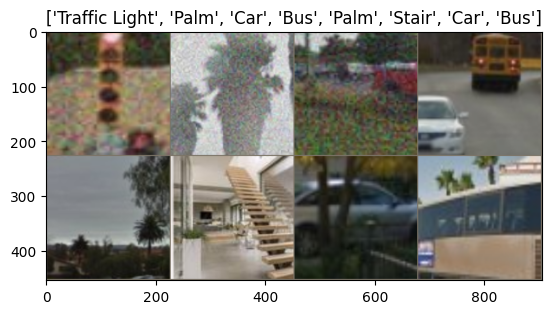

In [155]:
imshow(out, title=[image_dataset.classes[x] for x in tl])